In [1]:
%matplotlib inline
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import pandas as pd
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.io import loadmat

from aux import loadmat_h5, get_seg, get_outliers, mv_avg, align_t
from disp import set_plot, plot_b

T_MAX = 600
T = np.arange(T_MAX)
NROI = 20

T_SINE = np.array([40, 70, 100])
T_PULSE = np.array([130, 160, 190])
T_NAT = np.array([220, 300, 380, 460])

FLY_IDX = 2

FLIES = ['220815_a1', '220824_a2', '220825_a1']
EXPTS = [
    [f'{FLIES[0]}_{ctr+1}' for ctr in range(2)],
    [f'{FLIES[1]}_{ctr+1}_behavioronly' for ctr in range(3)],
    [f'{FLIES[2]}_{ctr+1}' for ctr in range(6)],
]

BHV_IDX_FRAME = 1
BHV_IDX_TIME = 21
BHV_IDX_SPEED = 18
DT_BHV = 0.5

FNAME_STIM = 'data/original/lin_imaging/nat_song_imaging/10min_blocksplus_stim_1_forplotting.mat'
SAVE_DIR = f'data/view/lin_20220830'

In [2]:
# load stim
stims = loadmat(FNAME_STIM)
stim_pulse = stims['pulse_song'].flatten()
stim_sine = stims['sine_song'].flatten()
tstim = stims['stim_time'].flatten()

stim = np.zeros(len(tstim), dtype=int)
stim[stim_sine > 0] = 1
stim[stim_pulse > 0] = 2

In [3]:
# load behav
expts = EXPTS[FLY_IDX]
ntr = len(expts)

tbhvs = []
spds = []

for expt in expts:

    fname_bhv = f'data/original/lin_imaging/nat_song_imaging/{expt}/output.txt'
    data_dir = f'data/original/lin_imaging/nat_song_imaging/{expt}/supervoxels/'

    df_bhv = pd.read_csv(fname_bhv, header=None)

    # df_bhv
    tbhv = np.array(df_bhv)[:, BHV_IDX_TIME] - np.array(df_bhv)[0, BHV_IDX_TIME]  # converts to time in seconds
    spd = np.array(df_bhv)[:, BHV_IDX_SPEED]
    
    tbhvs.append(tbhv)
    spds.append(spd)
    
# clean up time vectors and signal alignment
tbase, spds = align_t(tbhvs, spds, dt=DT_BHV)

In [4]:
# extend stim vec to match behav
dt_stim = np.mean(np.diff(tstim))
tstim = np.arange(0, tbase[-1]+dt_stim, dt_stim)
stim_ = np.zeros(len(tstim))
stim_[:len(stim)] = stim
stim = stim_

mtstim_sine_0 = ((T_SINE[0]-5) < tstim) & (tstim < (T_SINE[0]+15))
mtstim_pulse_0 = ((T_PULSE[0]-5) < tstim) & (tstim < (T_PULSE[0]+15))
mtstim_nat_0 = ((T_NAT[0] - 5) <= tstim) & (tstim < T_NAT[0] + 65)

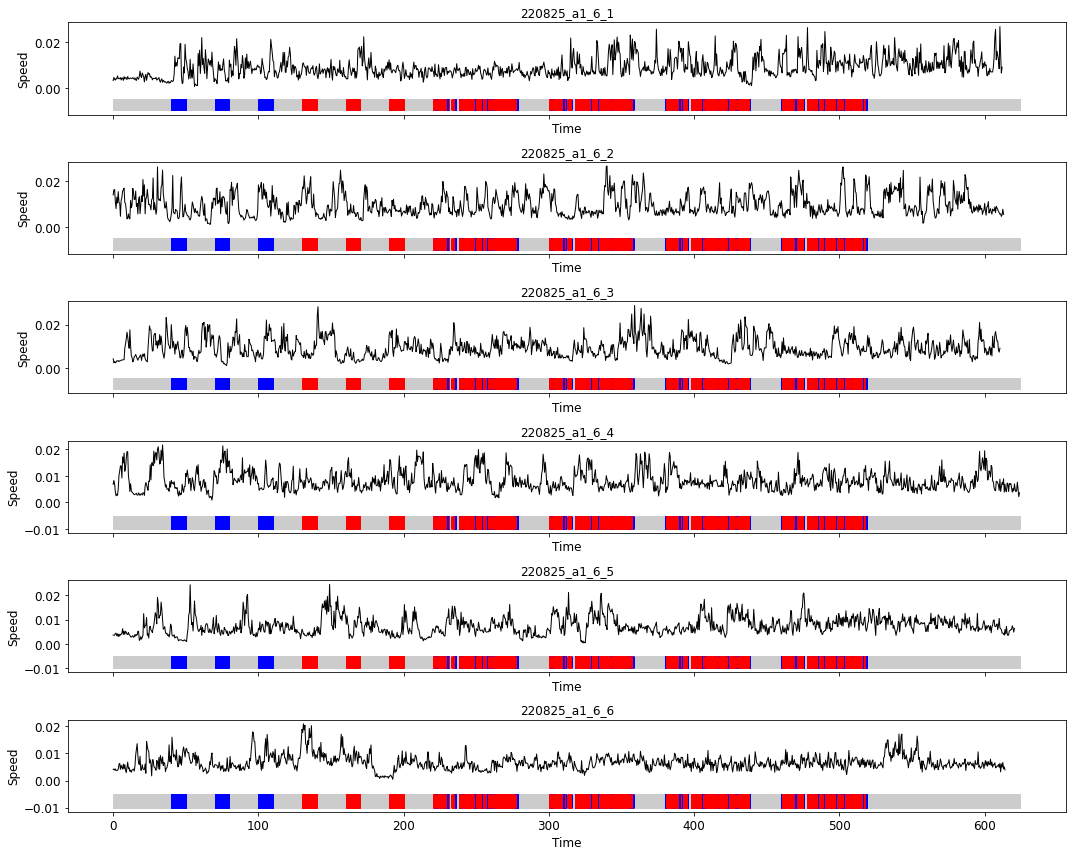

In [5]:
# plot behav
fig, axs = plt.subplots(ntr, 1, figsize=(15, 2*ntr), tight_layout=True, sharex=True)

for ctr, (spd, ax) in enumerate(zip(spds, axs)):

    # plot stim and behav
    ax.plot(tbase, spd, c='k', lw=1)
    plot_b(ax, tstim, stim, extent=[0, tstim.max(), -.01, -.005], c=[(.8, .8, .8), 'b', 'r'])
    set_plot(ax, x_label='Time', y_label='Speed', title=f'{expt}_{ctr+1}', font_size=12)

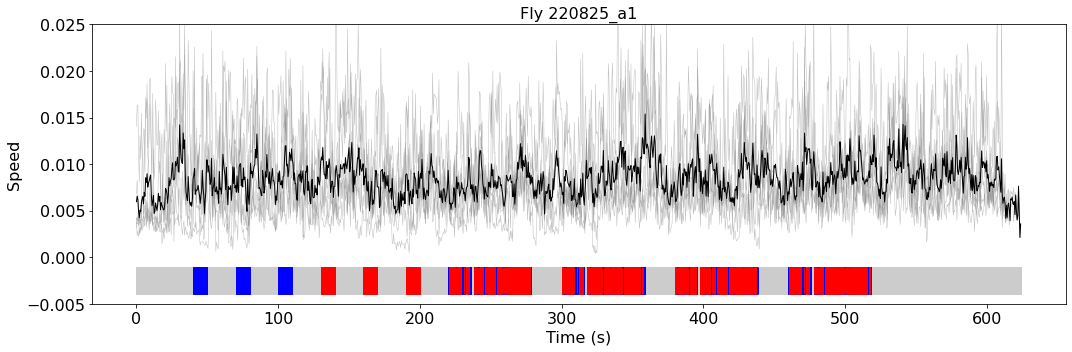

In [6]:
# plot overlaid/mean walking speeds
fig, ax = plt.subplots(1, 1, figsize=(15, 5), tight_layout=True)
for spd in spds:
    ax.plot(tbase, spd, lw=.5, c='gray', alpha=.5)
    
ax.plot(tbase, np.nanmean(spds, axis=0), lw=1, c='k')
plot_b(ax, tstim, stim, extent=[0, tstim.max(), -.004, -.001], c=[(.8, .8, .8), 'b', 'r'])
set_plot(
    ax, y_lim=(-0.005, .025),
    x_label='Time (s)', y_label='Speed', title=f'Fly {FLIES[FLY_IDX]}', font_size=16)

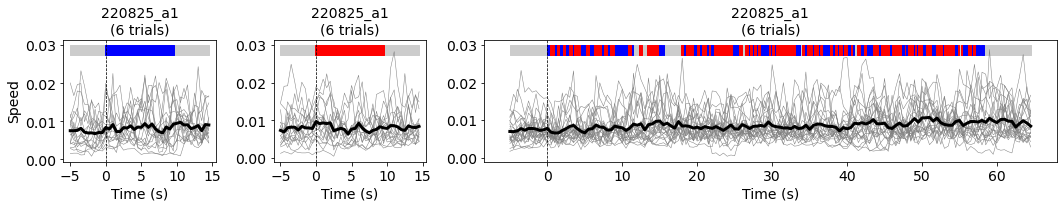

In [7]:
# get behav responses triggered on stim type
tsine = np.arange(-5, 15, DT_BHV)
spds_sine = []
tpulse = np.arange(-5, 15, DT_BHV)
spds_pulse = []
tnat = np.arange(-5, 65, DT_BHV)
spds_nat = []
for spd in spds:
    # sine response
    for t_0 in T_SINE:
        mt = ((t_0-5) <= tbase) & (tbase < (t_0+15))
        spds_sine.append(spd[mt])
        
    # pulse response
    for t_0 in T_PULSE:
        mt = ((t_0-5) <= tbase) & (tbase < (t_0+15))
        spds_pulse.append(spd[mt])
    
    # nat response
    for t_0 in T_NAT:
        mt = ((t_0-5) <= tbase) & (tbase < (t_0+65))
        spds_nat.append(spd[mt])
        
spds_sine = np.array(spds_sine)
spds_pulse = np.array(spds_pulse)
spds_nat = np.array(spds_nat)

gs = gridspec.GridSpec(1, 5)
fig = plt.figure(figsize=(15, 3), tight_layout=True)
axs = [
    fig.add_subplot(gs[0]),  # sine
    fig.add_subplot(gs[1]),  # pulse 
    fig.add_subplot(gs[2:]),  # nat song
]

axs[0].plot(tsine, spds_sine.T, lw=.5, c='gray')
axs[0].plot(tsine, np.nanmean(spds_sine, axis=0), lw=3, c='k')
plot_b(axs[0], tsine, stim[mtstim_sine_0], extent=[tsine[0], tsine[-1], .0275, .03], c=[(.8, .8, .8), 'b', 'r'])

axs[1].plot(tpulse, spds_pulse.T, lw=.5, c='gray')
axs[1].plot(tpulse, np.nanmean(spds_pulse, axis=0), lw=3, c='k')
plot_b(axs[1], tpulse, stim[mtstim_pulse_0], extent=[tpulse[0], tpulse[-1], .0275, .03], c=[(.8, .8, .8), 'b', 'r'])

axs[2].plot(tnat, spds_nat.T, lw=.5, c='gray')
axs[2].plot(tnat, np.nanmean(spds_nat, axis=0), lw=3, c='k')
plot_b(axs[2], tnat, stim[mtstim_nat_0], extent=[tnat[0], tnat[-1], .0275, .03], c=[(.8, .8, .8), 'b', 'r'])

axs[0].set_ylabel('Speed')
for ax in axs:
    ax.axvline(0, ls='--', c='k', lw=.75)
    set_plot(ax, x_label='Time (s)', title=f'{FLIES[FLY_IDX]}\n({ntr} trials)', font_size=14)